# Cleanup: remove `children_of_new_layers` variable

We have a hypothesis that this mechanism covers less cases than a more recent `previous` structure. And we want to check if it's safe to delete a variable, making overall code simpler.

In [1]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from operator import itemgetter
from random import randint
from typing import Any, Callable, Union, Optional

In [2]:
from siebenapp import RenderRow, RenderResult
from sieben_example1 import EXAMPLE as rr0

Drawing function, improved to print downgoing edges.

In [3]:
def draw(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            if ypos[row_id] > ypos[e]:
                print(f"downgoing edge: {row_id}@{ypos[row_id]} -> {e}@{ypos[e]}")
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

downgoing edge: 1@5 -> 5@4
downgoing edge: 1@5 -> 40@0
downgoing edge: 3@7 -> 6@2
downgoing edge: 3@7 -> 8@1
downgoing edge: 3@7 -> 30@5
downgoing edge: 3@7 -> 37@2
downgoing edge: 5@4 -> 6@2
downgoing edge: 5@4 -> 8@1
downgoing edge: 7@9 -> 9@3
downgoing edge: 7@9 -> 16@0
downgoing edge: 9@3 -> 11@2
downgoing edge: 9@3 -> 13@1
downgoing edge: 9@3 -> 15@1
downgoing edge: 18@4 -> 23@2
downgoing edge: 19@9 -> 21@0
downgoing edge: 20@3 -> 21@0
downgoing edge: 24@8 -> 18@4
downgoing edge: 27@10 -> 18@4
downgoing edge: 30@5 -> 31@3
downgoing edge: 30@5 -> 33@2
downgoing edge: 30@5 -> 35@4
downgoing edge: 30@5 -> 36@1
downgoing edge: 37@2 -> 16@0
downgoing edge: 37@2 -> 42@1
downgoing edge: 46@8 -> 47@3
downgoing edge: 46@8 -> 48@0
downgoing edge: 49@7 -> 50@2


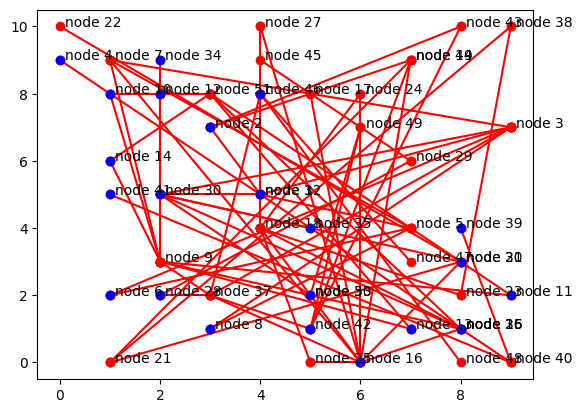

In [4]:
draw(rr0)

A lot of downgoing edges, as expected. Nodes are placed at random, ignoring ordering.


## Before cleanup

Some common code, used in both implementations.

In [5]:
@dataclass
class RenderStep:
    rr: RenderResult
    roots: list[int]
    layers: list[list[int]]
    previous: dict[int, list[int]]


def pp(step: RenderStep):
    return [step.roots, step.layers]


def add_if_not(m: dict, m1: dict) -> dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

In [6]:
def find_previous(rr: RenderResult) -> dict[int, list[int]]:
    result: dict[int, list[int]] = {g: [] for g in rr.roots}
    to_visit: set[int] = set(rr.roots)
    while to_visit:
        g = to_visit.pop()
        connections = [e[0] for e in rr.by_id(g).edges]
        for g1 in connections:
            to_visit.add(g1)
            result[g1] = result.get(g1, []) + [g]
    return result

In [7]:
# Rendering defaults
WIDTH = 5

A previous version of `tube` function.

In [8]:
def tube0(step: RenderStep):
    children_of_new_layer: Set[int] = set()
    new_layer: List[int] = []
    already_added: Set[int] = set(g for l in step.layers for g in l)
    for goal_id in step.roots:
        if len(new_layer) >= WIDTH:
            break
        if (goal_id not in children_of_new_layer) and \
            (all(g in already_added for g in step.previous[goal_id])):
            new_layer.append(goal_id)
            children_of_new_layer.update(e[0] for e in step.rr.by_id(goal_id).edges)
    new_roots: List[int] = step.roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    new_layers = step.layers + [new_layer]
    already_added.update(set(g for l in new_layers for g in l))
    filtered_roots: List[int] = []
    for g in new_roots:
        if g not in already_added:
            filtered_roots.append(g)
            already_added.add(g)
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            filtered_roots,
            new_layers,
            step.previous)

Run full render loop with an old function.

In [9]:
def build_with(rr: RenderResult, fn: Callable[[RenderStep], RenderStep]) -> RenderStep:
    step = RenderStep(rr, list(rr.roots), [], find_previous(rr))
    while step.roots:
        step = fn(step)
    return step

In [10]:
r0 = build_with(rr0, tube0)
pp(r0)

[[],
 [[1],
  [2, 3, 4, 5, 40],
  [6, 7, 8, 30, 37],
  [39, 41, 9, 16, 31],
  [32, 33, 34, 35, 36],
  [28, 42, 46, 10, 11],
  [12, 13, 14, 15, 17],
  [19, 20, 24, 25, 26],
  [27, 29, 43, 44, 49],
  [47, 48, 51, 21, 22],
  [18, 45, 50],
  [23],
  [38]]]

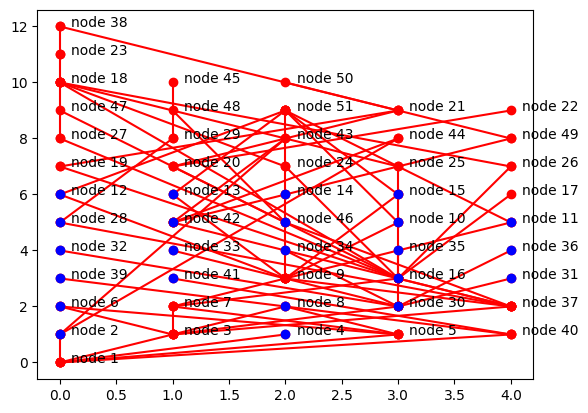

In [11]:
draw(r0.rr)

## After cleanup

So, let's simply remove `children_of_new_layers` variable and everything that's related to it.

In [12]:
def tube(step: RenderStep):
    new_layer: List[int] = []
    already_added: Set[int] = set(g for l in step.layers for g in l)
    for goal_id in step.roots:
        if len(new_layer) >= WIDTH:
            break
        if (all(g in already_added for g in step.previous[goal_id])):
            new_layer.append(goal_id)
    new_roots: List[int] = step.roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    new_layers = step.layers + [new_layer]
    already_added.update(set(g for l in new_layers for g in l))
    filtered_roots: List[int] = []
    for g in new_roots:
        if g not in already_added:
            filtered_roots.append(g)
            already_added.add(g)
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            filtered_roots,
            new_layers,
            step.previous)

In [13]:
r1 = build_with(rr0, tube)
pp(r1)

[[],
 [[1],
  [2, 3, 4, 5, 40],
  [6, 7, 8, 30, 37],
  [39, 41, 9, 16, 31],
  [32, 33, 34, 35, 36],
  [28, 42, 46, 10, 11],
  [12, 13, 14, 15, 17],
  [19, 20, 24, 25, 26],
  [27, 29, 43, 44, 49],
  [47, 48, 51, 21, 22],
  [18, 45, 50],
  [23],
  [38]]]

In [14]:
r0 == r1

True

Two results are really identical, that's good.

## Next steps

What else could we improve? I have a hypothesis that we could use a kind of "virtual layers" when placing nodes. Instead of tracking and updating "previous" nodes, we could calculate "minimal virtual layer" for each of the node. Upon creating a `new_roots` variable, we sort ids by their virtual layers. When creating a `new_layer`, we take no more than `WIDTH` goals with the same virtual layer value. No need to track parents anymore.

Having this idea in mind, and considering "backlog" from the previous part, we have the following items now:

1. Try **virtual layers** instead of tracking "previous nodes".
2. **Performance**. There's still a room for improvement. It's not cool to have things like `new_opts = {... for goal_id, opts in step.rr.node_opts.items()`. We visit literally all nodes in `rr` while update only some of them. This place (and, probably, several others) should be reviewed and rewritten.
3. **Multiple roots**. We need to re-check algorithm for graph containing multiple root nodes. We could have either several not-connected sub-graphs (a result of filtering, for example), or sub-graphs that have some intermediate connections between them. Probably, an energy-based logic would be more useful here. Nevertheless, we _may have_ to modify an existing `energy` function in a way that only the shortest edge is considered.
4. **Fake goals**. In order to draw edges properly, we need to add "fake goals" (intersection points between edge and current layer). Current version of algorithm knows nothing about it.
5. **Horizontal adjustment tweaking**. It also _seems_ that the new generated graph could be additionally improved by horizontal adjustments. Is it true?